In [1]:
import os

expirement_tag = '5-08-Exp2'

intensity_rel_filename = '../data/' + expirement_tag + '/intensityrel.mat'
location_filename = '../data/'+ expirement_tag + '/location.mat'

base_path = './pickle/' + expirement_tag + '_'
base_path_artifacts = './artifacts/' + expirement_tag + "_"

%matplotlib inline

## Load matlab data

In [2]:
import scipy.io
import numpy as np

intensity_matlab_file = scipy.io.loadmat(intensity_rel_filename)

In [3]:
def plot_4_diffrent_response_curve(intensity_matlab_file, base_path_artifacts):
    import matplotlib
    import matplotlib.pyplot as plt

    def plot_intensity(ax, i):
        ax.plot(intensity_matlab_file['intensity'][i])
        ax.set_title('Cell ' + str(i))
        ax.set_xlabel('Time')
        ax.set_ylabel('Calcium Intensity')
    
    fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
    plot_intensity(axes[0, 0], 0)
    plot_intensity(axes[0, 1], 1)
    plot_intensity(axes[1, 0], 66)
    plot_intensity(axes[1, 1], 67)

    fig.suptitle('Cell Intensity')

    plt.subplots_adjust(hspace = 0.5)
    fig.savefig(base_path_artifacts + '4_diffrent_response_curve.png')
    plt.clf()
    plt.close(fig)

plot_4_diffrent_response_curve(intensity_matlab_file, base_path_artifacts) 

### Preprocessing - Smooth Signals

In [4]:
from module.preprocessing import smooth

cells_intensity = smooth(intensity_matlab_file['intensity'])

print('The shape of the signal\'s data:' + str(cells_intensity.shape))

The shape of the signal's data:(674, 1022)


## Preprocssing - Numerically Differentiated the Response Curve

In [5]:
from module.preprocessing import first_derive_cells_intensity

normalized_cells_response_curve = first_derive_cells_intensity(cells_intensity)

### Mean Response Curve

In [6]:
def calc_mean_response_curve(cells_intensity):
    avg_intensity = np.zeros((cells_intensity.shape[1]))
    
    min_intensity = np.zeros((cells_intensity.shape[1])) + 1
    max_intensity = np.zeros((cells_intensity.shape[1])) - 1

    for cell_idx,cell_intensity in enumerate(cells_intensity):
        avg_intensity += cell_intensity
        #min_intensity = np.minimum(min_intensity, cell_intensity)
        #max_intensity = np.maximum(max_intensity, cell_intensity)    
    
    std_intensity = np.std(cells_intensity, axis=0)    
    avg_intensity = avg_intensity / cells_intensity.shape[0]
    
    return avg_intensity, std_intensity

mean_normalized_cells_response_curve, std_normalized_cells_response_curve = calc_mean_response_curve(normalized_cells_response_curve)

## Find Peaks Analysis

In [7]:
len(mean_normalized_cells_response_curve)

1017

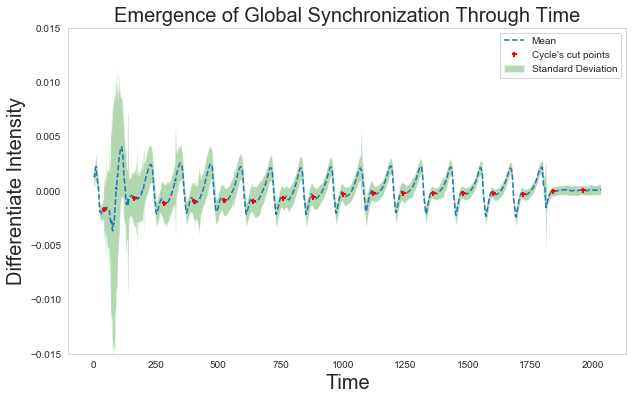

<Figure size 432x288 with 0 Axes>

In [8]:
def plot_peaks_analysis(indexes, mean_normalized_cells_response_curve, std_normalized_cells_response_curve, base_path):
    import matplotlib
    import matplotlib.pyplot as plt
    import peakutils
    from peakutils.plot import plot as pplot
    import seaborn as sns

    sns.set_style("whitegrid", {'axes.grid' : False, 'font_scale': 2})

    x = np.linspace(0, len(mean_normalized_cells_response_curve), len(mean_normalized_cells_response_curve))
    
    x = x * 2

    fig, ax = plt.subplots(figsize=(10,6))
    pplot(x, mean_normalized_cells_response_curve, indexes)
    ax.fill_between(x, 
                     y1=mean_normalized_cells_response_curve - std_normalized_cells_response_curve, 
                     y2=mean_normalized_cells_response_curve + std_normalized_cells_response_curve, 
                     facecolor='Green', alpha=0.3)
    ax.set_ylim(-0.015, 0.015)

    plt.legend(['Mean', 'Cycle\'s cut points', 'Standard Deviation'])

    plt.title('Emergence of Global Synchronization Through Time', fontsize=20)
    plt.xlabel('Time', fontsize=20)
    plt.ylabel('Differentiate Intensity', fontsize=20)
    plt.xlim = 0
    #fig.savefig(base_path + 'peaks_analysis.png')
    #fig.savefig(base_path + 'peaks_analysis.eps', format='eps')
    plt.show()
    plt.clf()
    plt.close(fig)

indexes = list(range(20, 1000, 60))

plot_peaks_analysis(indexes, mean_normalized_cells_response_curve, 

                    std_normalized_cells_response_curve, base_path_artifacts)

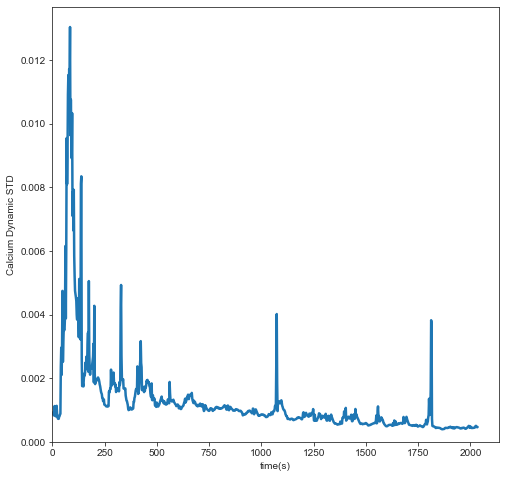

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("ticks", {'axes.grid' : False, 'font_scale': 2, "xtick.major.size": 20, "ytick.major.size": 20})

fig = plt.figure(figsize=(8,8))

x = np.linspace(0, len(mean_normalized_cells_response_curve), len(mean_normalized_cells_response_curve))

x = x * 2

ax = sns.lineplot(y=std_normalized_cells_response_curve, x=x, palette="tab10", linewidth=2.5)

ax.set(xlabel="time(s)", ylabel="Calcium Dynamic STD")

ax.set(ylim=0)
ax.set(xlim=0)

plt.show()

fig.savefig(base_path_artifacts + '_calcium_dynamic_std' + '.eps', format='eps')
fig.savefig(base_path_artifacts + '_calcium_dynamic_std' + '.png')

plt.clf()
plt.close(fig)

## Divide the frames by the peaks

In [10]:
from module.helpers import divide_frames_by_indices

indexes_activation_time = list(range(30, 1000, 60))

cells_response_curve_parts = divide_frames_by_indices(indexes, normalized_cells_response_curve)
cells_response_curve_parts_activiation_time = divide_frames_by_indices(indexes_activation_time, cells_intensity)

activation_time_curve_parts = cells_response_curve_parts_activiation_time

### Validate that the time series is stationary

In [11]:
from module.stathelper import validate_stationary
import warnings

p_value_results_adf, p_value_results_kpss = None, None

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    p_value_results_adf, p_value_results_kpss  = validate_stationary(normalized_cells_response_curve)

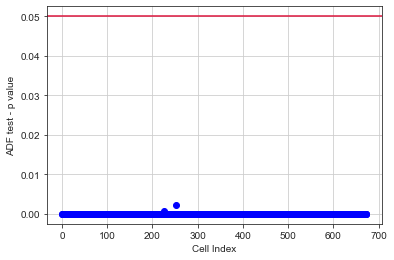

In [12]:
import matplotlib.pyplot as plt

plt.plot(p_value_results_adf, 'bo')

p_line = plt.axhline(0.05, color="crimson")

plt.xlabel('Cell Index')
plt.ylabel('ADF test - p value')
plt.grid(True)

plt.show()

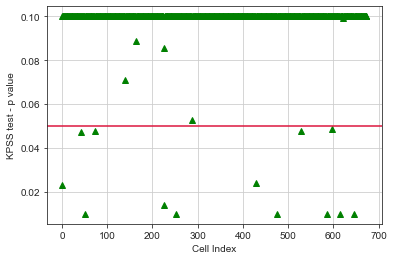

In [13]:
import matplotlib.pyplot as plt

plt.plot(p_value_results_kpss, 'g^')

p_line = plt.axhline(0.05, color="crimson")

plt.xlabel('Cell Index')
plt.ylabel('KPSS test - p value')
plt.grid(True)

plt.show()

### Filter out cells which have non-stationary response curve

In [14]:
kpss_filter = [True if p_value > 0.05 else False for p_value in p_value_results_kpss]
adf_filter = [True if p_value <= 0.05 else False for p_value in p_value_results_adf]

kpss_and_adf_filter = np.logical_and(kpss_filter, adf_filter)

np.sum(kpss_and_adf_filter) / float(len(kpss_and_adf_filter))

0.9807121661721068

In [15]:
kpss_and_adf_filter[0]

False

## Voronoi diagram

### load centroids data

In [16]:
location_matlab_file = scipy.io.loadmat(location_filename)

centroids = location_matlab_file['centroids']

In [17]:
from scipy.spatial import ConvexHull
from module.topologicalhelper import area_of_rectangle, bounding_box
from module.topologicalhelper import split_to_small_bounding_boxes, filter_edges_in_bb_by_td, in_rect

hull = ConvexHull(centroids)

#print(hull.area)
rect_vert = bounding_box(centroids[hull.vertices])
#print(rect_vert)

#print(split_to_small_bounding_boxes(2, rect_vert))

print(centroids.shape[0])
area = area_of_rectangle(rect_vert[1][0]-rect_vert[0][0], rect_vert[2][1]-rect_vert[1][1])
area = area/(1000**2 * (0.656**2)) #convert to mm
print(1/area)
print(centroids.shape[0]*(1/(area)))

674
The Area of the Rectangle is 674500.0
0.6380074128984433
430.0169962935508


In [18]:
from scipy.spatial import Voronoi, voronoi_plot_2d
from module.topologicalhelper import voronoi_finite_polygons_2d

vor = Voronoi(centroids)

regions, vertices = voronoi_finite_polygons_2d(vor)

def plot_voronoi(regions, vertices, vor, points):
    
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for region in regions:
        polygon = vertices[region]
        ax.fill(*zip(*polygon), alpha=0.7)
    
    ax.plot(points[:,0], points[:,1], 'ko')
    ax.set_xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
    ax.set_ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)
    
    #plt.savefig("voronoi.png", dpi=800)
    plt.show()

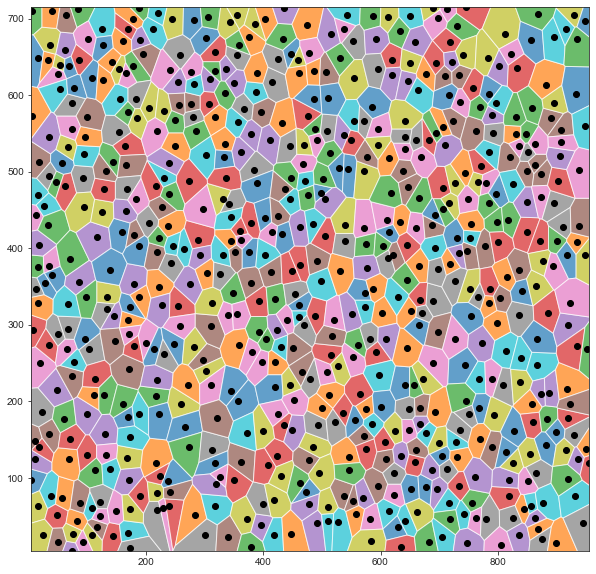

In [19]:
plot_voronoi(regions, vertices, vor, centroids)

## Delaunay triangulation

In [20]:
from scipy.spatial import Delaunay
from module.topologicalhelper import find_neighbors

tri = Delaunay(centroids)

In [21]:
neighbor_indices = find_neighbors(tri, centroids)
#neighbor_indices[0]

## Serialization Stuff

In [22]:
from module.serializationhelper import save_object, load_object

In [23]:
analyze_result_df = load_object(base_path + 'analyze_result_df')

analyze_cell_stats = load_object(base_path + 'analyze_cell_stats')

file is not exist path:./pickle/5-08-Exp2_analyze_cell_stats


In [24]:
from module.stathelper import validate_stationary
import warnings

p_value_results_adf_part, p_value_results_kpss_part = None, None

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    p_value_results_adf_part, p_value_results_kpss_part  = validate_stationary(cells_response_curve_parts[14])

kpss_filter_part = [True if p_value > 0.05 else False for p_value in p_value_results_kpss_part]
adf_filter_part = [True if p_value <= 0.05 else False for p_value in p_value_results_adf_part]

kpss_and_adf_filter_part = np.logical_and(kpss_filter_part, adf_filter_part)

np.sum(kpss_and_adf_filter_part) / float(len(kpss_and_adf_filter_part))

0.13649851632047477

## Analyze GC

In [25]:
import importlib
import modulev2.analyzetools
from modulev2.analyzetools import analyze_network

if analyze_result_df is None:
    analyze_result_df = analyze_network(neighbor_indices, cells_response_curve_parts, kpss_and_adf_filter, 2)
    
    analyze_result_df['total_neighbours'] = analyze_result_df.groupby(['source', 'part'])['destination'].transform(lambda x: x.count())
    analyze_result_df['critical_value'] = 0.05 / analyze_result_df['total_neighbours']
    analyze_result_df['significant'] = analyze_result_df['granger_causality_pvalue'] < analyze_result_df['critical_value']
    analyze_result_df['significant'] = analyze_result_df['significant'].astype(int)
    
    save_object(analyze_result_df, base_path + 'analyze_result_df')

In [26]:
analyze_result_df

,source,destination,part,topological_distance,optimal_lag,granger_causality_mag,granger_causality_pvalue,total_neighbours,critical_value,significant
0,1.0,2.0,0.0,1.0,2.0,-0.270397,7.727845e-04,36.0,0.001389,1
1,1.0,3.0,0.0,1.0,2.0,-0.032793,4.193681e-01,36.0,0.001389,0
2,1.0,36.0,0.0,1.0,6.0,-1.555034,2.207141e-12,36.0,0.001389,1
3,1.0,6.0,0.0,1.0,2.0,-0.191482,6.255608e-03,36.0,0.001389,0
4,1.0,39.0,0.0,1.0,4.0,-0.887405,1.300743e-08,36.0,0.001389,1
...,...,...,...,...,...,...,...,...,...,...
12269,673.0,651.0,15.0,2.0,2.0,-0.161323,1.391128e-02,23.0,0.002174,0
12270,673.0,654.0,15.0,2.0,3.0,-0.082352,2.448839e-01,23.0,0.002174,0
12271,673.0,656.0,15.0,2.0,2.0,-0.003647,9.078754e-01,23.0,0.002174,0
12272,673.0,663.0,15.0,2.0,4.0,-0.187436,6.129889e-02,23.0,0.002174,0


## Transfer Entropy

In [27]:
from pathlib import Path

graphs_path  = './artifacts/graphs/'

Path(graphs_path).mkdir(parents=True, exist_ok=True)

In [33]:
import networkx as nx

def write_graph_file(graph: nx.Graph, path: str):
    with open(path, 'w') as file:
        file.write(str(graph.number_of_nodes()) + '\n')
        for src_key, dst_key in nx.edges(graph):
            file.write(f'{src_key} {dst_key}\n')

In [37]:
import transfer_entropy

for cycle in [9, 10]:
    spatial_graph = load_object(base_path + 'spatial_graph_' +str(cycle) + '_lag_12')
    if spatial_graph is None:
        spatial_graph = transfer_entropy.build_spatial_graph(neighbor_indices, cells_response_curve_parts, tpd=1, kpss_and_adf_filter=kpss_and_adf_filter)

        idtxlte_analyzer = transfer_entropy.IdtxlTE(use_gpu=True, parallel=False)
        idtxlte_analyzer.analyze_network(spatial_structure=spatial_graph, cycle=cycle, fixed_lag=12)

        save_object(spatial_graph, base_path + 'spatial_graph_' +str(cycle) + '_lag_12')
    write_graph_file(spatial_graph.export_networkx(), graphs_path + expirement_tag + 'graph_cycle_' + str(cycle))

    print('finish to analyze cycle ' + str(cycle))

file is not exist path:./pickle/5-08-Exp2_spatial_graph_9_lag_12


Adding data with properties: 10 processes, 60 samples, 1 replications
overwriting existing data

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 100
testing candidate: (0, 12) maximum statistic, n_perm: 100
testing candidate: (0, 4) maximum statistic, n_perm: 100
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (5, 1),

Adding data with properties: 10 processes, 60 samples, 1 replications
overwriting existing data

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8, 9]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 100
testing candidate: (0, 11) maximum statistic, n_perm: 100
testing candidate: (0, 7) maximum statistic, n_perm: 100
testing candidate: (0, 10) maximum statistic, n_perm: 100
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), 